<a href="https://colab.research.google.com/github/sekihiro/Colabo/blob/master/Seq2Seq_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorchでAttention-Seq2Seq
- 様々な日付の書き方をYYYY-MM-DDのフォーマットに変換
- https://qiita.com/m__k/items/646044788c5f94eadc8d
- Attentionのざっくり説明
 - Encoder側の各隠れ層の値をすべてDecoder側の各層に渡す
 - Decoder側の各層において、Encoder側から渡された各隠れ層のベクトルのうち、最も注意すべきベクトルを選び出して特徴に加える

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!nvidia-smi
!nvcc -V
!cat /usr/include/cudnn.h | grep CUDNN_MAJOR -A 2

Sat Feb 22 14:03:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    34W / 250W |    735MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import os
import sys
import pprint
import random
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.display import Image, display_png
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
# 再現性確保
def seed_everything(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    return seed

# 再現性確保
ret = seed_everything(1234)
print('seed : {}'.format(ret))

# select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device : {}'.format(device))

seed : 1234
device : cuda


### 定数定義

In [0]:
BASE_PATH = "/content/drive/My Drive/git/data_conversion/"
FILE_PATH = BASE_PATH + 'date_conversion.txt'

TRAIN_RATIO = 0.7

DATA_CNT = 50000
#DATA_CNT = 10

BATCH_NUM = 100
EPOCH_NUM = 50
#BATCH_NUM = 2
#EPOCH_NUM = 1

embedding_dim = 200 # 文字の埋め込み次元数
hidden_dim = 128 # LSTMの隠れ層のサイズ

## データ準備
- https://github.com/oreilly-japan/deep-learning-from-scratch-2/tree/master/dataset


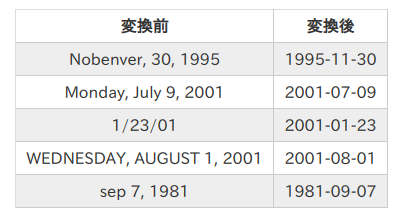

In [27]:
display_png(Image("/content/drive/My Drive/git/images/date_conversion.png"))
# 下記のような変換を行う

In [28]:
input_date = [] # 変換前の日付データ
output_date = [] # 変換後の日付データ

# date_conversion.txtを1行ずつ読み込んで変換前と変換後に分割して、inputとoutputで分ける
with open(FILE_PATH, "r") as f:
    date_list = f.readlines()
    for i, date in enumerate(date_list):
        date = date[:-1]
        if i <= 1:
            print('date = ({})'.format(date))
        input_date.append(date.split("_")[0])
        output_date.append("_" + date.split("_")[1])

print('input_date = [{}, {}, ・・・'.format(input_date[0], input_date[1]))
print('output_date = [{}, {}, ・・・'.format(output_date[0], output_date[1]))

# inputとoutputの系列の長さを取得
# すべて長さが同じなので、0番目の要素でlenを取ってます
input_len = len(input_date[0]) # 29
output_len = len(output_date[0]) # 10

# date.txtで登場するすべての文字にIDを割り当てる
char2id = {}
for input_chars, output_chars in zip(input_date, output_date):
    for c in input_chars:
        if not c in char2id:
            char2id[c] = len(char2id)
    for c in output_chars:
        if not c in char2id:
            char2id[c] = len(char2id)
print('\nlen(char2id) = {}'.format(len(char2id)))
print(char2id)
print('\n')

input_data = [] # ID化された変換前日付データ
output_data = [] # ID化された変換後日付データ
for input_chars, output_chars in zip(input_date, output_date):
    input_data.append([char2id[c] for c in input_chars])
    output_data.append([char2id[c] for c in output_chars])
print('input_data = [{}, {}, ・・・'.format(input_data[0], input_data[1]))
print('output_data = [{}, {}, ・・・'.format(output_data[0], output_data[1]))

# 7:3でtrainとtestに分ける
train_x, test_x, train_y, test_y = train_test_split(input_data, output_data, train_size= TRAIN_RATIO)
print('\nlen(train_x) = {:,}'.format(len(train_x)))
print('len(train_y) = {:,}'.format(len(train_y)))
print('len(test_x)  = {:,}'.format(len(test_x)))
print('len(test_y)  = {:,}'.format(len(test_y)))

date = (september 27, 1994           _1994-09-27)
date = (August 19, 2003              _2003-08-19)
input_date = [september 27, 1994           , August 19, 2003              , ・・・
output_date = [_1994-09-27, _2003-08-19, ・・・

len(char2id) = 59
{'s': 0, 'e': 1, 'p': 2, 't': 3, 'm': 4, 'b': 5, 'r': 6, ' ': 7, '2': 8, '7': 9, ',': 10, '1': 11, '9': 12, '4': 13, '_': 14, '-': 15, '0': 16, 'A': 17, 'u': 18, 'g': 19, '3': 20, '8': 21, '/': 22, 'T': 23, 'U': 24, 'E': 25, 'S': 26, 'D': 27, 'Y': 28, 'P': 29, 'M': 30, 'B': 31, 'R': 32, '5': 33, 'J': 34, 'N': 35, '6': 36, 'a': 37, 'i': 38, 'l': 39, 'O': 40, 'c': 41, 'o': 42, 'G': 43, 'F': 44, 'y': 45, 'n': 46, 'C': 47, 'W': 48, 'd': 49, 'I': 50, 'L': 51, 'j': 52, 'H': 53, 'v': 54, 'h': 55, 'V': 56, 'f': 57, 'w': 58}


input_data = [[0, 1, 2, 3, 1, 4, 5, 1, 6, 7, 8, 9, 10, 7, 11, 12, 12, 13, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], [17, 18, 19, 18, 0, 3, 7, 11, 12, 10, 7, 8, 16, 16, 20, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], ・・・
output_data = [[14, 1

In [0]:
# データをバッチ化するための関数を定義
def train2batch(input_data, output_data, batch_size=BATCH_NUM):
    input_batch = []
    output_batch = []
    input_shuffle, output_shuffle = shuffle(input_data, output_data)
    for i in range(0, len(input_data), batch_size):
        input_batch.append(input_shuffle[i:i+batch_size])
        output_batch.append(output_shuffle[i:i+batch_size])

    return input_batch, output_batch

## Encoder

In [0]:
vocab_size = len(char2id) # 扱う文字の数

# Encoderクラス
class Encoder(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        # 親クラスのコンストラクタ。決まり文句
        super(Encoder, self).__init__()
        # 隠れ層の次元数
        self.hidden_dim = hidden_dim
        # インプットの単語をベクトル化するために使う
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=char2id[" "])
        # 隠れ層
        # 少しでも楽したいので、LSTMはGRU(Gated Recurrent Unit)に変えてます
        # GRUとは、LSTMの忘却ゲートと入力ゲートを単一の更新ゲートにマージし
        # 隠れ状態のみを伝達していくニューラルネットワークのモデル
        # GRUのメリットは、LSTMと比べて学習パラメータが少ないためより短い時間で学習することができるという点に
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, sequence):
        # 文章内の各単語をベクトル化して出力。
        embedding = self.word_embeddings(sequence)
        # hsが各系列のGRUの隠れ層のベクトル
        # Attentionされる要素
        hs, h = self.gru(embedding)
    
        return hs, h

## Decoder

In [0]:
# Attention Decoderクラス
class AttentionDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size):
        super(AttentionDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=char2id[" "])
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        # hidden_dim*2としているのは、各系列のGRUの隠れ層とAttention層で計算したコンテキストベクトルをtorch.catでつなぎ合わせることで長さが２倍になるため
        self.hidden2linear = nn.Linear(hidden_dim * 2, vocab_size)
        # 列方向を確率変換したいのでdim=1
        self.softmax = nn.Softmax(dim=1)

    def forward(self, sequence, hs, h):
        embedding = self.word_embeddings(sequence)
        output, state = self.gru(embedding, h)

        # Attention層
        # hs.size() = ([100, 29, 128])
        # output.size() = ([100, 10, 128])

        # bmmを使ってEncoder側の出力(hs)とDecoder側の出力(output)をbatchごとまとめて行列計算するために、Decoder側のoutputをbatchを固定して転置行列を取る
        t_output = torch.transpose(output, 1, 2) # t_output.size() = ([100, 128, 10])

        # bmmでバッチも考慮してまとめて行列計算
        s = torch.bmm(hs, t_output) # s.size() = ([100, 29, 10])

        # 列方向(dim=1)でsoftmaxをとって確率表現に変換
        # この値を後のAttentionの可視化などにも使うため、returnで返しておく
        attention_weight = self.softmax(s) # attention_weight.size() = ([100, 29, 10])

        # コンテキストベクトルをまとめるために入れ物を用意
        c = torch.zeros(self.batch_size, 1, self.hidden_dim, device=device) # c.size() = ([100, 1, 128])

        # 各DecoderのGRU層に対するコンテキストベクトルをまとめて計算する方法がわからなかったので、
        # 各層（Decoder側のGRU層は生成文字列が10文字なので10個ある）におけるattention weightを取り出してforループ内でコンテキストベクトルを１つずつ作成する
        # バッチ方向はまとめて計算できたのでバッチはそのまま
        for i in range(attention_weight.size()[2]): # 10回ループ

            # attention_weight[:,:,i].size() = ([100, 29])
            # i番目のGRU層に対するattention weightを取り出すが、テンソルのサイズをhsと揃えるためにunsqueezeする
            unsq_weight = attention_weight[:,:,i].unsqueeze(2) # unsq_weight.size() = ([100, 29, 1])

            # hsの各ベクトルをattention weightで重み付けする
            weighted_hs = hs * unsq_weight # weighted_hs.size() = ([100, 29, 128])

            # attention weightで重み付けされた各hsのベクトルをすべて足し合わせてコンテキストベクトルを作成
            weight_sum = torch.sum(weighted_hs, axis=1).unsqueeze(1) # weight_sum.size() = ([100, 1, 128])

            c = torch.cat([c, weight_sum], dim=1) # c.size() = ([100, i, 128])

        # 箱として用意したzero要素が残っているのでスライスして削除
        c = c[:,1:,:]

        output = torch.cat([output, c], dim=2) # output.size() = ([100, 10, 256])
        output = self.hidden2linear(output)

        return output, state, attention_weight

## モデル宣言、損失関数、最適化

In [0]:
encoder = Encoder(vocab_size, embedding_dim, hidden_dim).to(device)
attn_decoder = AttentionDecoder(vocab_size, embedding_dim, hidden_dim, BATCH_NUM).to(device)

# 損失関数
criterion = nn.CrossEntropyLoss()

# 最適化
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
attn_decoder_optimizer = optim.Adam(attn_decoder.parameters(), lr=0.001)

## 学習

In [33]:
all_losses = []
print("training ...")

for epoch in range(1, EPOCH_NUM+1):

    epoch_loss = 0 # epoch毎のloss

    # データをミニバッチに分ける
    # train_x : 変換前文字列
    # train_y : 変換後文字列
    input_batch, output_batch = train2batch(train_x, train_y, batch_size=BATCH_NUM)

    for i in range(len(input_batch)):

        # 勾配の初期化
        # モデルが持ってる勾配の情報をリセット
        # 毎回バックプロパゲーションの初期値をリセット(勾配リセット)
        encoder_optimizer.zero_grad()
        attn_decoder_optimizer.zero_grad()

        # データをテンソルに変換
        input_tensor = torch.tensor(input_batch[i], device=device)
        output_tensor = torch.tensor(output_batch[i], device=device)

        # Encoderの順伝搬(forwardが呼ばれる)
        hs, h = encoder(input_tensor)

        # Attention Decoderのインプット
        source = output_tensor[:, :-1]

        # Attention Decoderの正解データ
        target = output_tensor[:, 1:]

        loss = 0
        decoder_output, _, attention_weight= attn_decoder(source, hs, h)
        for j in range(decoder_output.size()[1]):
            # バッチ毎にまとめてloss計算
            loss += criterion(decoder_output[:, j, :], target[:, j])

        epoch_loss += loss.item()

        # 誤差逆伝播
        # 誤差のバックプロパゲーション(逆伝播)で勾配を求める
        loss.backward()

        # パラメータ更新
        # Encoder、Decoder両方学習
        # バックプロパゲーションで計算した勾配を元に重みを更新
        encoder_optimizer.step()
        attn_decoder_optimizer.step()

    # 損失を表示
    print("Epoch {} : loss -> {:.5f}".format(epoch, epoch_loss))
    all_losses.append(epoch_loss)
    #if epoch_loss < 0.1: break

print("\n Done ... ")

training ...
Epoch 1 : loss -> 1606.11248
Epoch 2 : loss -> 83.32915
Epoch 3 : loss -> 40.94904
Epoch 4 : loss -> 4.41860
Epoch 5 : loss -> 2.15113
Epoch 6 : loss -> 1.42788
Epoch 7 : loss -> 12.20765
Epoch 8 : loss -> 2.39774
Epoch 9 : loss -> 1.00541
Epoch 10 : loss -> 0.64023
Epoch 11 : loss -> 0.44977
Epoch 12 : loss -> 0.33413
Epoch 13 : loss -> 0.25694
Epoch 14 : loss -> 0.20159
Epoch 15 : loss -> 0.16055
Epoch 16 : loss -> 0.12928
Epoch 17 : loss -> 0.10493
Epoch 18 : loss -> 0.08559
Epoch 19 : loss -> 0.07016
Epoch 20 : loss -> 0.05771
Epoch 21 : loss -> 0.04767
Epoch 22 : loss -> 0.03937
Epoch 23 : loss -> 0.03257
Epoch 24 : loss -> 0.02703
Epoch 25 : loss -> 0.02247
Epoch 26 : loss -> 0.01866
Epoch 27 : loss -> 0.01552
Epoch 28 : loss -> 0.01286
Epoch 29 : loss -> 0.01076
Epoch 30 : loss -> 0.00902
Epoch 31 : loss -> 0.00748
Epoch 32 : loss -> 0.00618
Epoch 33 : loss -> 0.00504
Epoch 34 : loss -> 0.00413
Epoch 35 : loss -> 0.00339
Epoch 36 : loss -> 0.00278
Epoch 37 : loss ->

## 損失可視化

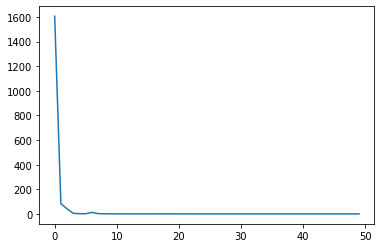

In [34]:
plt.plot(all_losses)

## 予測

In [36]:
# Decoderのアウトプットのテンソルから要素が最大のインデックスを返す。つまり生成文字を意味する
def get_max_index(decoder_output):
    results = []
    for h in decoder_output:
        results.append(torch.argmax(h))

    return torch.tensor(results, device=device).view(BATCH_NUM, 1)

# 評価用データ
test_input_batch, test_output_batch = train2batch(test_x, test_y)
input_tensor = torch.tensor(test_input_batch, device=device)

predicts = []
for i in range(len(test_input_batch)):

    # torch.no_gradで必要のない計算を停止 パラメータの保存を止める(test時にメモリが溢れてしまうのを防止)
    with torch.no_grad():

        hs, encoder_state = encoder(input_tensor[i])

        # Decoderにはまず文字列生成開始を表す"_"をインプットにするので、"_"のtensorをバッチサイズ分作成
        start_char_batch = [[char2id["_"]] for _ in range(BATCH_NUM)]
        decoder_input_tensor = torch.tensor(start_char_batch, device=device)

        # 変数名変換
        decoder_hidden = encoder_state

        # バッチ毎の結果を結合するための入れ物を定義
        batch_tmp = torch.zeros(100, 1, dtype=torch.long, device=device)

        for _ in range(output_len - 1):
            decoder_output, decoder_hidden, _ = attn_decoder(decoder_input_tensor, hs, decoder_hidden)
            # 予測文字を取得しつつ、そのまま次のdecoderのインプットとなる
            # torch.squeezeは要素数が1のみの軸を削除してくれます
            decoder_input_tensor = get_max_index(decoder_output.squeeze())
            # バッチ毎の結果を予測順に結合
            # torch.cat : torch.Tensorをリスト入れてして渡すことで、それらを連結したTensorを返してくれます
            # 連結する軸はdimによって指定します。
            batch_tmp = torch.cat([batch_tmp, decoder_input_tensor], dim=1)

        # 最初のbatch_tmpの0要素が先頭に残ってしまっているのでスライスして削除
        predicts.append(batch_tmp[:,1:])


# 予測結果を見る際にIDのままだと可読性が悪いので、もとの文字列に復元するためのID→文字列に変換する辞書を定義
id2char = {}
for k, v in char2id.items():
    id2char[v] = k

row = []
for i in range(len(test_input_batch)):
    batch_input = test_input_batch[i]
    batch_output = test_output_batch[i]
    batch_predict = predicts[i]
    for inp, output, predict in zip(batch_input, batch_output, batch_predict):
        x = [id2char[idx] for idx in inp]
        y = [id2char[idx] for idx in output[1:]]
        p = [id2char[idx.item()] for idx in predict]

        x_str = "".join(x)
        y_str = "".join(y)
        p_str = "".join(p)

        judge = "ok" if y_str == p_str else "ng"
        row.append([x_str, y_str, p_str, judge])
        
predict_df = pd.DataFrame(row, columns=["input", "answer", "predict", "judge"])
predict_df.head()

,input,answer,predict,judge
0,11/6/80,1980-11-06,1980-11-06,ok
1,"august 20, 1970",1970-08-20,1970-08-20,ok
2,"OCTOBER 13, 1982",1982-10-13,1982-10-13,ok
3,6/11/78,1978-06-11,1978-06-11,ok
4,"monday, august 22, 1994",1994-08-22,1994-08-22,ok


## 正解率

In [38]:
print(len(predict_df.query('judge == "ok"')) / len(predict_df))
# 0.9999333333333333

predict_df.query('judge == "X"').head(10)

1.0


,input,answer,predict,judge


## attention weight 可視化
- attention weightの可視化にはよくheatmapが使われるので、seabornのheatmapで可視化してます。
- 7:3に分けた3のほうのテストデータをバッチに分けたうちの最初のミニバッチを流しています

tensor([[3.8613e-19, 2.1273e-08, 1.0920e-11, 1.3520e-07, 4.7374e-15, 9.3962e-09,
         1.8438e-11, 9.9449e-14, 4.0167e-14, 1.0976e-11],
        [2.3630e-16, 7.7201e-11, 2.3466e-12, 2.3124e-10, 4.3433e-21, 9.4143e-08,
         3.4364e-11, 2.4530e-18, 2.8647e-12, 1.0042e-14],
        [4.3589e-11, 8.9699e-14, 1.1024e-13, 1.6823e-10, 9.9200e-21, 1.8709e-06,
         4.7812e-05, 7.5254e-18, 6.0440e-11, 5.6571e-12],
        [6.4459e-09, 1.1317e-09, 1.2131e-13, 2.2339e-10, 9.6251e-21, 1.1122e-05,
         4.8886e-12, 6.5853e-18, 1.0930e-04, 9.1550e-12],
        [8.9942e-15, 4.6273e-14, 5.7590e-14, 2.0403e-11, 1.1818e-14, 5.1227e-04,
         2.4171e-15, 1.4330e-13, 4.3779e-08, 3.6600e-11],
        [6.2632e-16, 2.4635e-05, 2.7967e-13, 2.8888e-11, 9.2278e-19, 3.9172e-08,
         1.0939e-06, 2.4177e-13, 1.5965e-11, 9.6128e-08],
        [5.4190e-14, 1.0299e-05, 1.8777e-10, 1.0730e-12, 3.6394e-17, 4.0926e-11,
         4.5602e-10, 2.2201e-09, 2.1429e-08, 3.2797e-07],
        [5.2689e-07, 7.8872

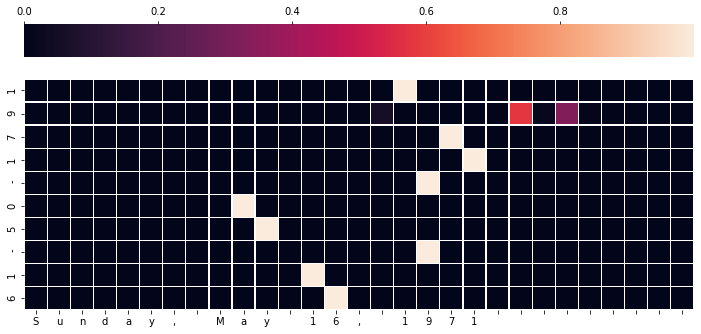

In [46]:
input_batch, output_batch = train2batch(test_x, test_y, batch_size=BATCH_NUM)
input_minibatch, output_minibatch = input_batch[0], output_batch[0]

with torch.no_grad():
    # データをテンソルに変換
    input_tensor = torch.tensor(input_minibatch, device=device)
    output_tensor = torch.tensor(output_minibatch, device=device)
    hs, h = encoder(input_tensor)
    source = output_tensor[:, :-1]
    decoder_output, _, attention_weight= attn_decoder(source, hs, h)

for i in range(1):
    with torch.no_grad():
        pprint.pprint(attention_weight[i])
        pprint.pprint(torch.transpose(attention_weight[i], 0, 1))
        # torch.transpose で行と列を入れ替え(転置)
        # columns(列)：変換前文字列の表示用
        # index(行)：変換後文字列の表示用
        df = pd.DataFrame(data=torch.transpose(attention_weight[i], 0, 1).cpu().numpy(), 
                    columns=[id2char[idx.item()] for idx in input_tensor[i]], 
                    index=[id2char[idx.item()] for idx in output_tensor[i][1:]])
        print(df)
        plt.figure(figsize=(12, 8)) 
        sns.heatmap(df, xticklabels = 1, yticklabels = 1, square=True, linewidths=.3,
                        cbar_kws = dict(use_gridspec=False,location="top"))

###### heatmapの説明
- 下の文字が変換前の文字列 (左から読む)
- 左の縦に並んでいる文字列が生成文字 (上から読む)
- 生成文字を１文字ずつ見たとき、左に並んでいるボックスの色が一番明るいところの文字に一番attentionして生成された文字ですという意味
- 左方向にボックスの値をすべて足せば1になる

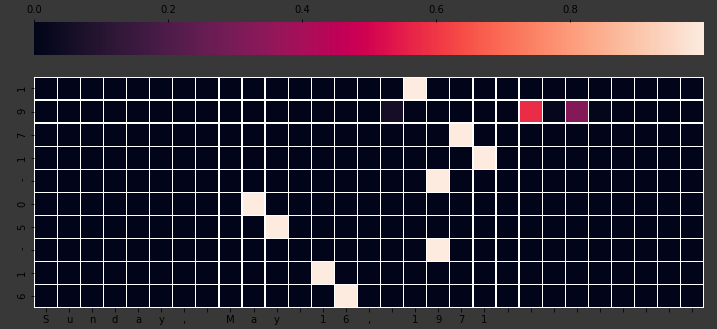

In [48]:
# 例
display_png(Image("/content/drive/My Drive/git/images/seq2seq05.png"))

- seq2seq05.png の考察
 - 曜日の変換は無いため、Sundayの文字は全く注目されていない
 - Mayのaを0が注目している。Marchは03でMayは05だから、Maとなったときに0が確定し、次いでMayとなったときに5が確定した。